##Seminário SO - Ext4
Antonio Maldonado 790038  
Geovanne Mansano 791072  
Matheus Menecucci 800310  
Yago David Pimenta 800273

## **Introdução**
---  
O primeiro sistema de arquivos feito para o Linux foi o **Minix**, entretando devido a diversos problemas de desempenho outro sistema de arquivos foi criado para substituí-lo, chamado *extended file system* (**Ext**). Seu criador foi Remy Card que o lançou em 1992, sendo o primeiro sistema de arquivos com suporte ao VFS (Virtual File System). 
Um ano após, em 1993, foi lançado o **Ext2**, sendo incrementado pelo mesmo criador, que trouxe algumas novas funcionalidades como o Fast Files System (FFS). 

O terceiro *extended file system* (**Ext3**) teve um maior avanço nos sitemas de arquivos do Linux, trazendo o conceito de *journaling*, que aumenta a confiabilidade do sistema de arquivos quando o sistema é parado bruscamente. Esse sistema de arquivos foi implementado por Stephen Tweedie e lançado em 2001.

Já atualmente, temos o **Ext4** como a quarta versão do *extended file system*, que foi desenvolvido por um time de desenvolvedores liderado por Theodore Tso e lançado em 2008. Esta versão trouxe diversas melhorias que envolvem diversos novos recursos como escalabilidade, reusabilidade, funcionalidades novas e performance. Sendo este o tema abordado nesta apresentação.



### Evolução dos *Extended File System*




<figure>
  <center> 
    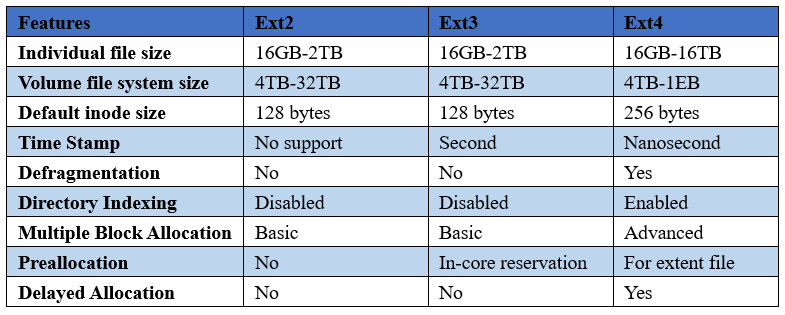
  <figcaption>Comparação entre os Ext's</figcaption>
</figure>


### Novidades do Ext4 

- Melhora no *timestamp*: o suporte das versões anteriores ao Ext4 era baseado em segundos, sendo substituído por nanosegundos, em resposta as maiores demandas computacionais em relação a velocidade das operações no processador serem muito maiores e promover maior integração (processamento multi-core);
- Tamanho dos arquivos: oferece um aumento do volume do sistema de arquivos com tamanho de até 1 exabyte (1000 petabytes), e arquivos de até 16TB;
- Extensões (*extends*): nova forma de alocação que promove maior escalabilidade e suporte para o crescimento de arquivos com uma estrutura de armazenamento mais eficiente;
- Compatibilidade com o Ext3;
- Pré-alocação: implementa a pré-alocação de grandes seções de blocos contínuos no tamanho desejado através de uma nova chamada de sistema, sedo utilizada para diminuir a fragmentação;
- *Delayed allocation* (alocação atrasada): atrasa a alocação dos blocos físicos no disco até que eles sejam liberados para serem escritos nele, para que mais blocos sejam alocados de maneira contínua na memória melhorando sua optimização;
- Desfragmentação Online: desfragmenta as partições e os arquivos para melhoria de performance, através da cópia dos arquivos para um novo *inode* com referência para uma extensão contínua.

## **Estrutura de um sistema de arquivo**
---

Sistemas de arquivos são armazenados em discos, podendo ser divididos em partições com sistemas de arquivos independentes em
cada uma delas. A organização interna dos diferentes tipos de sistema de arquivos diferem bastante entre si, entretanto pode haver também estruturas padrões comuns entre eles. Abaixo têm-se um esquema genérico de um sistema de arquivos com suas respectivas estruturas.



<figure>
  <center> 
    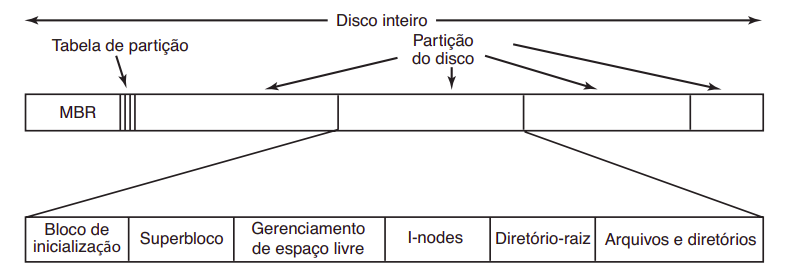
  <figcaption>Layout genérico de um sistema de arquivos</figcaption>
  </center>
</figure>

*   *MBR (Master Boot Record)* : Ele é utilizado para inicilizar o computador, em que a BIOS lê esse setor em que nele vai conter uma tabela de partição que indica o começo e o fim de cada partição. Por padrão, ele vai localizar a primeira partição ativa e ler nela o seu bloco de inicialização.

*   *Block Group*: Uniformemente, cada partição vai ter um **bloco de inicialização**, que armazena o sistema operacional contido naquela partição. Além disso, têm o **superbloco**, em que ao inicializar o computador ou toda vez que o sistema de arquivos é montado, ele é lido para memória, pois ele contém todos os parêmetros-chave do sistema de arquivos. Há também informações a respeito de blocos que estão disponíveis no sistema de arquivos por meio do mecanismo de **bitmap** ou **lista e ponteiros**. Em sequência, têm-se os **i-nodes**, que  são uma estrutura de dados que armazena informações importantes sobre os arquivos, em que sua identificação é feita por metadados. Bem como o **diretório-raiz** que contém o topo da árvore do sistema de arquivos, e a parte restante do disco contém demais **arquivos e diretórios**.

### **Estrutura do Ext4**

Um sistema de arquivos Ext4 é dividido em uma série de **grupos de blocos**. Para reduzir as dificuldades de desempenho devido à fragmentação, o alocador de blocos se esforça muito para manter os blocos de cada arquivo dentro do mesmo grupo, reduzindo assim os tempos de busca (*seeking*). Com o **tamanho de bloco padrão de 4KiB**, cada grupo conterá 32.768 blocos, para um comprimento de **128MiB**. O número de grupos de blocos é o tamanho do dispositivo dividido pelo tamanho de um grupo de blocos.


<figure>
  <center> 
    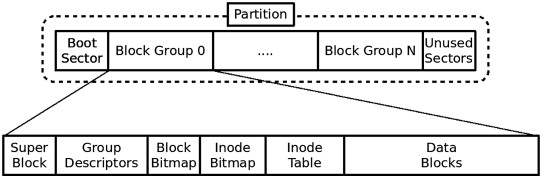
  <figcaption>Layout sistema de arquivos Ext</figcaption>
  </center>
</figure>


### **Blocos**

O Ext4 aloca espaço de armazenamento em **unidades de blocos**, em que um bloco é um grupo de setores entre 1KiB e 64KiB, e o número de setores deve ser uma potência integral de 2. Os blocos, por sua vez, são agrupados em unidades maiores chamadas **grupos de blocos**. O tamanho do bloco é normalmente de 4KiB. Por padrão, um sistema de arquivos pode conter 2^32 blocos para a arquitetura de 32 bits, e 2^64 blocos para 64 bits.

<figure>
  <center>
  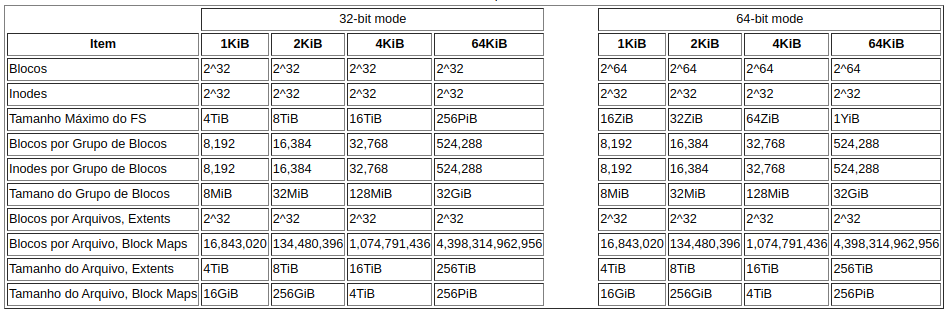Tamanho máximo do sistema de arquivo</figcaption>
  </center>
</figure>

  O tamanho de um grupo de blocos é especificado pela variável *s_blocks_per_group*, sendo definida no cabeçalho do código fonte do linux [ext4.h](https://elixir.bootlin.com/linux/v5.19.9/source/fs/ext4/ext4.h), e armazenada na estrutura *ext4_super_block* mais detelhada a frente. Assim como demais informações como tamanho de descritor mínimo, número de clusters por grupo (*s_clusters_per_group*), inodes por grupo (*s_inodes_per_group*), etc.




```
* Macro-instructions used to manage group descriptors
 */
#define EXT4_MIN_DESC_SIZE		32
#define EXT4_MIN_DESC_SIZE_64BIT	64
#define	EXT4_MAX_DESC_SIZE		EXT4_MIN_BLOCK_SIZE
#define EXT4_DESC_SIZE(s)		(EXT4_SB(s)->s_desc_size)
#ifdef __KERNEL__
# define EXT4_BLOCKS_PER_GROUP(s)	(EXT4_SB(s)->s_blocks_per_group)
# define EXT4_CLUSTERS_PER_GROUP(s)	(EXT4_SB(s)->s_clusters_per_group)
# define EXT4_DESC_PER_BLOCK(s)		(EXT4_SB(s)->s_desc_per_block)
# define EXT4_INODES_PER_GROUP(s)	(EXT4_SB(s)->s_inodes_per_group)
# define EXT4_DESC_PER_BLOCK_BITS(s)	(EXT4_SB(s)->s_desc_per_block_bits)
#else
# define EXT4_BLOCKS_PER_GROUP(s)	((s)->s_blocks_per_group)
# define EXT4_DESC_PER_BLOCK(s)		(EXT4_BLOCK_SIZE(s) / EXT4_DESC_SIZE(s))
# define EXT4_INODES_PER_GROUP(s)	((s)->s_inodes_per_group)
#endif
```


#### **Grupos de Blocos**

O esquema de organização dos grupos de blocos é feito desta forma:






<figure>
  <center>
  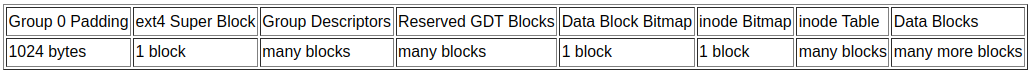
  <figcaption>Organização dos grupos de blocos</figcaption>
  </center>
</figure>



Os primeiros 1024 bytes que representam o grupo zero não são utilizados, ficando disponíveis para a instalação das seções de boot do x86 e outros dados, represeantando o **Group Zero**. O *Super Block* por sua vez será inicializado logo após o grupo 0, ou seja, com um offset de 1024 bytes.

Primeiramente o driver trabalha com o **Super Block** e o **Group Descriptors**, explicados melhor posteriormente. Em que são escritas <u>cópias redundantes</u> de ambos, em alguns grupos de blocos no decorrer do disco, para garantir que em caso do início do disco seja danificado, essas informações possam permanecer seguras. Caso não haja uma cópia redundante para o grupo de blocos, este comecará com o *Data Block Bitmap*.

Entre o *Group Descriptors* e o *Data Block Bitmap* é mantido a área de **Reserved GDT Blocks** (*s_reserved_gdt_blocks*, presente no *Super Block*), que permite a futura expansão do sistema de arquivos em até 1024 vezes seu tamanho original.
 
A organização do grupo de blocos apenas matêm o *Super Block* e o *Group Descriptor* no começo do grupo de blocos, já os *bitmaps* e a *tabela de inodes* podem estar localizados em qualquer posição. O espaço remanecente é utilizado para os *bloco de dados* (**Data Blocks**) dos arquivos, mapas de blocos indiretos, blocos de árvore de extensão e atributos extendidos.

## **Super Block**

Este bloco armazena diversas informações acerca do sistema de arquivos, como instruções de fechamento, contagem dos blocos, contagem dos inodes, informações de manutenção, funcionalidades suportadas, etc. O Ext4 *Super Block* é encontrado no arquivo de cabeçalho [ext4.h](https://elixir.bootlin.com/linux/v5.19.9/source/fs/ext4/ext4.h) como *struct ext4_super_block*, conforme se segue abaixo:


```
struct ext4_super_block {
/*00*/	__le32	s_inodes_count;		/* Inodes count */
	      __le32	s_blocks_count_lo;	/* Blocks count */
	      __le32	s_r_blocks_count_lo;	/* Reserved blocks count */
	      __le32	s_free_blocks_count_lo;	/* Free blocks count */
/*10*/	__le32	s_free_inodes_count;	/* Free inodes count */
	      __le32	s_first_data_block;	/* First Data Block */
	      __le32	s_log_block_size;	/* Block size */
	      __le32	s_log_cluster_size;	/* Allocation cluster size */
/*20*/	__le32	s_blocks_per_group;	/* # Blocks per group */
	      __le32	s_clusters_per_group;	/* # Clusters per group */
	      __le32	s_inodes_per_group;	/* # Inodes per group */
	      __le32	s_mtime;		/* Mount time */
/*30*/	__le32	s_wtime;		/* Write time */
	      __le16	s_mnt_count;		/* Mount count */
	      __le16	s_max_mnt_count;	/* Maximal mount count */
	      __le16	s_magic;		/* Magic signature */
	      __le16	s_state;		/* File system state */
	      __le16	s_errors;		/* Behaviour when detecting errors */
	      __le16	s_minor_rev_level;	/* minor revision level */
/*40*/	__le32	s_lastcheck;		/* time of last check */
	      __le32	s_checkinterval;	/* max. time between checks */
	      __le32	s_creator_os;		/* OS */
	      __le32	s_rev_level;		/* Revision level */
/*50*/	__le16	s_def_resuid;		/* Default uid for reserved blocks */
	      __le16	s_def_resgid;		/* Default gid for reserved blocks */
	/*
	 * These fields are for EXT4_DYNAMIC_REV superblocks only.
	 *
	 * Note: the difference between the compatible feature set and
	 * the incompatible feature set is that if there is a bit set
	 * in the incompatible feature set that the kernel doesn't
	 * know about, it should refuse to mount the filesystem.
	 *
	 * e2fsck's requirements are more strict; if it doesn't know
	 * about a feature in either the compatible or incompatible
	 * feature set, it must abort and not try to meddle with
	 * things it doesn't understand...
	 */
	      __le32	s_first_ino;		/* First non-reserved inode */
	      __le16  s_inode_size;		/* size of inode structure */
	      __le16	s_block_group_nr;	/* block group # of this superblock */
	      __le32	s_feature_compat;	/* compatible feature set */
/*60*/	__le32	s_feature_incompat;	/* incompatible feature set */
	      __le32	s_feature_ro_compat;	/* readonly-compatible feature set */
/*68*/	__u8	s_uuid[16];		/* 128-bit uuid for volume */
/*78*/	char	s_volume_name[EXT4_LABEL_MAX];	/* volume name */
/*88*/	char	s_last_mounted[64] __nonstring;	/* directory where last mounted */
/*C8*/	__le32	s_algorithm_usage_bitmap; /* For compression */
	      /*
	      * Performance hints.  Directory preallocation should only
	      * happen if the EXT4_FEATURE_COMPAT_DIR_PREALLOC flag is on.
	      */
	      __u8	s_prealloc_blocks;	/* Nr of blocks to try to preallocate*/
	      __u8	s_prealloc_dir_blocks;	/* Nr to preallocate for dirs */
	      __le16	s_reserved_gdt_blocks;	/* Per group desc for online growth */
	      /*
	      * Journaling support valid if EXT4_FEATURE_COMPAT_HAS_JOURNAL set.
	      */
/*D0*/	__u8	s_journal_uuid[16];	/* uuid of journal superblock */
/*E0*/	__le32	s_journal_inum;		/* inode number of journal file */
	      __le32	s_journal_dev;		/* device number of journal file */
	      __le32	s_last_orphan;		/* start of list of inodes to delete */
	      __le32	s_hash_seed[4];		/* HTREE hash seed */
	      __u8	s_def_hash_version;	/* Default hash version to use */
	      __u8	s_jnl_backup_type;
	      __le16  s_desc_size;		/* size of group descriptor */
/*100*/	__le32	s_default_mount_opts;
	      __le32	s_first_meta_bg;	/* First metablock block group */
	      __le32	s_mkfs_time;		/* When the filesystem was created */
	      __le32	s_jnl_blocks[17];	/* Backup of the journal inode */
	/* 64bit support valid if EXT4_FEATURE_COMPAT_64BIT */
/*150*/	__le32	s_blocks_count_hi;	/* Blocks count */
	      __le32	s_r_blocks_count_hi;	/* Reserved blocks count */
	      __le32	s_free_blocks_count_hi;	/* Free blocks count */
	      __le16	s_min_extra_isize;	/* All inodes have at least # bytes */
	      __le16	s_want_extra_isize; 	/* New inodes should reserve # bytes */
	      __le32	s_flags;		/* Miscellaneous flags */
	      __le16  s_raid_stride;		/* RAID stride */
	      __le16  s_mmp_update_interval;  /* # seconds to wait in MMP checking */
	      __le64  s_mmp_block;            /* Block for multi-mount protection */
	      __le32  s_raid_stripe_width;    /* blocks on all data disks (N*stride)*/
	      __u8	s_log_groups_per_flex;  /* FLEX_BG group size */
	      __u8	s_checksum_type;	/* metadata checksum algorithm used */
	      __u8	s_encryption_level;	/* versioning level for encryption */
	      __u8	s_reserved_pad;		/* Padding to next 32bits */
	      __le64	s_kbytes_written;	/* nr of lifetime kilobytes written */
	      __le32	s_snapshot_inum;	/* Inode number of active snapshot */
	      __le32	s_snapshot_id;		/* sequential ID of active snapshot */
	      __le64	s_snapshot_r_blocks_count; /* reserved blocks for active
					      snapshot's future use */
	      __le32	s_snapshot_list;	/* inode number of the head of the
					   on-disk snapshot list */
#define EXT4_S_ERR_START offsetof(struct ext4_super_block, s_error_count)
	      __le32	s_error_count;		/* number of fs errors */
	      __le32	s_first_error_time;	/* first time an error happened */
	      __le32	s_first_error_ino;	/* inode involved in first error */
	      __le64	s_first_error_block;	/* block involved of first error */
	      __u8	s_first_error_func[32] __nonstring;	/* function where the error happened */
	      __le32	s_first_error_line;	/* line number where error happened */
	      __le32	s_last_error_time;	/* most recent time of an error */
	      __le32	s_last_error_ino;	/* inode involved in last error */
	      __le32	s_last_error_line;	/* line number where error happened */
	      __le64	s_last_error_block;	/* block involved of last error */
	      __u8	s_last_error_func[32] __nonstring;	/* function where the error happened */
#define EXT4_S_ERR_END offsetof(struct ext4_super_block, s_mount_opts)
	      __u8	s_mount_opts[64];
	      __le32	s_usr_quota_inum;	/* inode for tracking user quota */
	      __le32	s_grp_quota_inum;	/* inode for tracking group quota */
	      __le32	s_overhead_clusters;	/* overhead blocks/clusters in fs */
	      __le32	s_backup_bgs[2];	/* groups with sparse_super2 SBs */
	      __u8	s_encrypt_algos[4];	/* Encryption algorithms in use  */
	      __u8	s_encrypt_pw_salt[16];	/* Salt used for string2key algorithm */
	      __le32	s_lpf_ino;		/* Location of the lost+found inode */
	      __le32	s_prj_quota_inum;	/* inode for tracking project quota */
	      __le32	s_checksum_seed;	/* crc32c(uuid) if csum_seed set */
	      __u8	s_wtime_hi;
	      __u8	s_mtime_hi;
	      __u8	s_mkfs_time_hi;
	      __u8	s_lastcheck_hi;
	      __u8	s_first_error_time_hi;
	      __u8	s_last_error_time_hi;
	      __u8	s_first_error_errcode;
	      __u8    s_last_error_errcode;
	      __le16  s_encoding;		/* Filename charset encoding */
	      __le16  s_encoding_flags;	/* Filename charset encoding flags */
	      __le32  s_orphan_file_inum;	/* Inode for tracking orphan inodes */
	      __le32	s_reserved[94];		/* Padding to the end of the block */
	      __le32	s_checksum;		/* crc32c(superblock) */
};

```



É possível encontrar informações sobre o Super Block e o groupo de blocos de sistemas de arquivos *Ext2*,*Ext3* e *Ext4* através do comando *dumpe2fs*, podendo ser observado os *backups* dessa estrutura presente no decorrer do disco:


```
sudo dumpe2fs <device> | grep -i superblock

  Primary superblock at 0, Group descriptors at 1-14
  Backup superblock at 32768, Group descriptors at 32769-32782
  Backup superblock at 98304, Group descriptors at 98305-98318
  Backup superblock at 163840, Group descriptors at 163841-163854
  Backup superblock at 229376, Group descriptors at 229377-229390
  Backup superblock at 294912, Group descriptors at 294913-294926
  Backup superblock at 819200, Group descriptors at 819201-819214
  Backup superblock at 884736, Group descriptors at 884737-884750
  Backup superblock at 1605632, Group descriptors at 1605633-1605646
  Backup superblock at 2654208, Group descriptors at 2654209-2654222
  Backup superblock at 4096000, Group descriptors at 4096001-4096014
  Backup superblock at 7962624, Group descriptors at 7962625-7962638
  Backup superblock at 11239424, Group descriptors at 11239425-11239438
  Backup superblock at 20480000, Group descriptors at 20480001-20480014
  Backup superblock at 23887872, Group descriptors at 23887873-23887886
```



### **Block Group Descriptor**

Cada grupo de blocos apresenta um descritor que contêm diversas informações cruciais associadas a ele, como o *bitmap* dos blocos, local do **bitmap dos inodes** (*bg_inode_bitmap_lo*) e da **tabela dos inodes** (*bg_inode_table_lo*), blocos livres, etc. Presente no código fonte do linux [ext4.h](https://elixir.bootlin.com/linux/v5.19.9/source/fs/ext4/ext4.h), como obervado abaixo:

```
* Structure of a blocks group descriptor
 */
struct ext4_group_desc
{
	__le32	bg_block_bitmap_lo;	/* Blocks bitmap block */
	__le32	bg_inode_bitmap_lo;	/* Inodes bitmap block */
	__le32	bg_inode_table_lo;	/* Inodes table block */
	__le16	bg_free_blocks_count_lo;/* Free blocks count */
	__le16	bg_free_inodes_count_lo;/* Free inodes count */
	__le16	bg_used_dirs_count_lo;	/* Directories count */
	__le16	bg_flags;		/* EXT4_BG_flags (INODE_UNINIT, etc) */
	__le32  bg_exclude_bitmap_lo;   /* Exclude bitmap for snapshots */
	__le16  bg_block_bitmap_csum_lo;/* crc32c(s_uuid+grp_num+bbitmap) LE */
	__le16  bg_inode_bitmap_csum_lo;/* crc32c(s_uuid+grp_num+ibitmap) LE */
	__le16  bg_itable_unused_lo;	/* Unused inodes count */
	__le16  bg_checksum;		/* crc16(sb_uuid+group+desc) */
	__le32	bg_block_bitmap_hi;	/* Blocks bitmap block MSB */
	__le32	bg_inode_bitmap_hi;	/* Inodes bitmap block MSB */
	__le32	bg_inode_table_hi;	/* Inodes table block MSB */
	__le16	bg_free_blocks_count_hi;/* Free blocks count MSB */
	__le16	bg_free_inodes_count_hi;/* Free inodes count MSB */
	__le16	bg_used_dirs_count_hi;	/* Directories count MSB */
	__le16  bg_itable_unused_hi;    /* Unused inodes count MSB */
	__le32  bg_exclude_bitmap_hi;   /* Exclude bitmap block MSB */
	__le16  bg_block_bitmap_csum_hi;/* crc32c(s_uuid+grp_num+bbitmap) BE */
	__le16  bg_inode_bitmap_csum_hi;/* crc32c(s_uuid+grp_num+ibitmap) BE */
	__u32   bg_reserved;
};

```

### **Inode**

O inode é apenas um índice de referência para um bloco de dados (unidade) que contém atributos e a localização do bloco de disco do objeto de dados. Pode incluir informações de metadados, como (horários da última alteração, acesso, modificação), bem como dados do proprietário e da permissão. Definida no arquivo de cabeçalho [ext4.h](https://elixir.bootlin.com/linux/v5.19.9/source/fs/ext4/ext4.h):

```
/*
 * Structure of an inode on the disk
 */
struct ext4_inode {
	__le16	i_mode;		/* File mode */
	__le16	i_uid;		/* Low 16 bits of Owner Uid */
	__le32	i_size_lo;	/* Size in bytes */
	__le32	i_atime;	/* Access time */
	__le32	i_ctime;	/* Inode Change time */
	__le32	i_mtime;	/* Modification time */
	__le32	i_dtime;	/* Deletion Time */
	__le16	i_gid;		/* Low 16 bits of Group Id */
	__le16	i_links_count;	/* Links count */
	__le32	i_blocks_lo;	/* Blocks count */
	__le32	i_flags;	/* File flags */
	union {
		struct {
			__le32  l_i_version;
		} linux1;
		struct {
			__u32  h_i_translator;
		} hurd1;
		struct {
			__u32  m_i_reserved1;
		} masix1;
	} osd1;				/* OS dependent 1 */
	__le32	i_block[EXT4_N_BLOCKS];/* Pointers to blocks */
	__le32	i_generation;	/* File version (for NFS) */
	__le32	i_file_acl_lo;	/* File ACL */
	__le32	i_size_high;
	__le32	i_obso_faddr;	/* Obsoleted fragment address */
	union {
		struct {
			__le16	l_i_blocks_high; /* were l_i_reserved1 */
			__le16	l_i_file_acl_high;
			__le16	l_i_uid_high;	/* these 2 fields */
			__le16	l_i_gid_high;	/* were reserved2[0] */
			__le16	l_i_checksum_lo;/* crc32c(uuid+inum+inode) LE */
			__le16	l_i_reserved;
		} linux2;
		struct {
			__le16	h_i_reserved1;	/* Obsoleted fragment number/size which are removed in ext4 */
			__u16	h_i_mode_high;
			__u16	h_i_uid_high;
			__u16	h_i_gid_high;
			__u32	h_i_author;
		} hurd2;
		struct {
			__le16	h_i_reserved1;	/* Obsoleted fragment number/size which are removed in ext4 */
			__le16	m_i_file_acl_high;
			__u32	m_i_reserved2[2];
		} masix2;
	} osd2;				/* OS dependent 2 */
	__le16	i_extra_isize;
	__le16	i_checksum_hi;	/* crc32c(uuid+inum+inode) BE */
	__le32  i_ctime_extra;  /* extra Change time      (nsec << 2 | epoch) */
	__le32  i_mtime_extra;  /* extra Modification time(nsec << 2 | epoch) */
	__le32  i_atime_extra;  /* extra Access time      (nsec << 2 | epoch) */
	__le32  i_crtime;       /* File Creation time */
	__le32  i_crtime_extra; /* extra FileCreationtime (nsec << 2 | epoch) */
	__le32  i_version_hi;	/* high 32 bits for 64-bit version */
	__le32	i_projid;	/* Project ID */
};

```

Abaixo têm-se o esquemático da estrutura de um inode:

<figure>
  <center>
  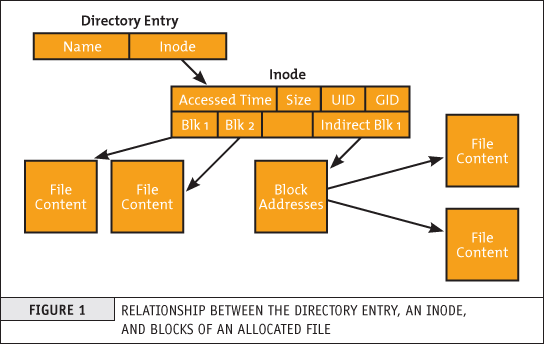
  <figcaption>Relação entre a entrada do diretório, inode e os blocos de um arquivo alocado</figcaption>
</figure>



### **Inode Bitmap & Inode Table**

O *inode bitmap* registra quais entradas na tabela de inode estão em uso. Como na maioria dos bitmaps, um bit representa o status de uso de um bloco de dados ou entrada de tabela de inodes. Isso implica um tamanho de grupo de blocos de 8 * *number_of_bytes_in_a_logical_block*.

O *inode table* é uma array linear da *struct ext4_inode*. A tabela é dimensionada para ter blocos suficientes para armazenar pelo menos *s_inode_size* * *s_inodes_per_group* bytes. 

Ambas estão definidas na estrutura do *Block Group Descriptor*, exibida anteriormente acima.

## **Journaling**
---

Se o sistema travar, ocorrer uma falha em disco, servidor ou até mesmo uma queda de energia, as alterações que não forem gravadas em nosso sistema de arquivo simplesmente serão descartada. É aí que o entra o processo de *Journaling*.  
Cada operação desse tipo é gravada primeiro no *Journal* e só posteriormente gravada no sistema de arquivos. Caso uma infelicidade como as citadas acima ocorra, provavelmente logo na próxima inicialização, o *Journal* é trazido de volta para o sistema para que as alterações sejam aplicadas e não perdidas.  Vale ressaltar que ele não é necessário para o funcionamento normal do sistema de arquivos, mas por motivos de desempenho e segurança, se torna um mecanismo bem útil.

O Journal pode ser usado em três modos diferentes que pode ser definido quando acionamos a montagem do sistema:

*  *Writeback mode*: Os dados podem ser gravados no ext4 antes ou depois de serem gravados no Journal. Em uma falha, novos dados ainda podem ser perdidos. Este modo normalmente fornecerá o melhor desempenho ext4.

*  *Ordered mode*: Este é o modo padrão. Todos os dados são enviados para ext4 e os metadados são enviados para o *Journal*. O sistema agrupa logicamente os metadados e os blocos de dados em uma única unidade. Quando é hora de gravar os novos metadados no disco, os blocos de dados associados são gravados primeiro. Em geral, esse modo é um pouco mais lento que o writeback, mas significativamente mais rápido que o *Journal mode*.

*  *Journal mode*: Tanto os dados quanto os metadados são gravados primeiro no journal para só depois serem gravados efetivamente. Logo, no caso de uma falha, o journal pode ser recuperado, trazendo dados e metadados para um estado consistente. Este modo é o mais lento, porém mais seguro.

O kernel do Linux trata as operações de forma diferentes para cada um dos modos.

Um fato interessante é que até mesmo outro dispositivo pode ser usado como *Journal*, mas normalmente Journal é um arquivo dentro do próprio ext4. Olhando para o Superblock, podemos vê-lo definido.

# ***Inicialização* : como o sistema operacional inicia e gerencia o sistema de arquivos**
---



O Sistema Operacional inicializa o sistema de arquivo através da chamada *ext4_init_fs*. Abaixo apresenta-se o código da função e comentários sobre as inicializações propostas.

```
static int __init ext4_init_fs(void)
{
	int i, err;

    //Limite de transferência da taxa de bytes por segundo
	ratelimit_state_init(&ext4_mount_msg_ratelimit, 30 * HZ, 64);

  /*
  Lazy init é um recurso que permite inicializar as inode tables gradualmente
  em segundo plano durante o processo de montagem, acelerando assim a criação
  do sistema.
  */
	ext4_li_info = NULL;

	/* Build-time check for flags consistency */
	ext4_check_flag_values();

    /* Fila de I/O assíncronos e extendeds */
	for (i = 0; i < EXT4_WQ_HASH_SZ; i++)
		init_waitqueue_head(&ext4__ioend_wq[i]);

  /*
  As inicializações a seguir são realizar pela fução kmem_cache_create
  ou a partir da struct kmem_cache (que contem o tamanho do objeto, 
  offset da região, flags e mais) retornando um ponteiro para o cache.
  */

  //Extent
	err = ext4_init_es();
	if (err)
		return err;
  //Reserva de clusters
	err = ext4_init_pending();
	if (err)
		goto out7;

  //Pos processamento de leitura da bios
	err = ext4_init_post_read_processing();
	if (err)
		goto out6;

	err = ext4_init_pageio();
	if (err)
		goto out5;

  /*
  Inicializa o nó para árvore rubro-negra utilizada e
  o tipo de dados para os blocos do sistema.
  */
	err = ext4_init_system_zone();
	if (err)
		goto out4;

  /* Cria a estrutura kobject e a define como um sistema de arquivo. */
	err = ext4_init_sysfs();
	if (err)
		goto out3;

  /*Por sua relevância vamos comentar mais dela adiante.*/
	err = ext4_init_mballoc();
	if (err)
		goto out2;

  /*
  Iniciliza os inode através da struct ext4_inode_info, o offset
  e o tamanho da região.
  */
	err = init_inodecache();
	if (err)
		goto out1;

	err = ext4_fc_init_dentry_cache();
	if (err)
		goto out05;

	register_as_ext3();
	register_as_ext2();
	err = register_filesystem(&ext4_fs_type);
	if (err)
		goto out;

	return 0;
out:
	unregister_as_ext2();
	unregister_as_ext3();
	ext4_fc_destroy_dentry_cache();
out05:
	destroy_inodecache();
out1:
	ext4_exit_mballoc();
out2:
	ext4_exit_sysfs();
out3:
	ext4_exit_system_zone();
out4:
	ext4_exit_pageio();
out5:
	ext4_exit_post_read_processing();
out6:
	ext4_exit_pending();
out7:
	ext4_exit_es();

	return err;
}
```



##**Como é realizada a alocação do sistema de arquivos do ext4**
---
É importante notar que até o ext3 no momento de realizar a gravação dos dados apenas um bloco era alocado por vez. Um dos fatores da melhora de desempenho do ext4 é a alocação em multiblocos tentando otimizar a alocação dos arquivos.  
Através da chamada *ext4_init_mballoc* o sistema operacional realizará a pré-alocação e alocação de nosso sistema de arquivos.  


#### Como funciona o *mballoc*?

O *mballoc* irá trabalhar com 3 dados: bitmap, in-core buddy e descritores de pré-alocação.  
O sistema irá realizar dois tipos de pré-alocação: 
- Inode: atribui a um inode específico, sendo o espaço apenas usado por ele. Descreve parte do espaço pré-alocado do inode um número específico de blocos físicos. O descritor contém apenas o número de blocos livres e não para um bloco em específico, logo deve-se ter certeza de que o bloco lógico correspondente ainda não foi alocado.
- Locality group: atribui a um gurpo especifico de inodes (o que não significa que o inode seja permanentemente daquele grupo). Nesse caso, o espaço poderá ser usado por qualquer inode.

A forma como o sistema é estruturado mantém o bloco com o mesmo status (seja de livre ou em uso) em todas suas estruturas, trazendo consistência a ele. Essa garantia permite o uso de variáveis que mantenham o número de blocos livres/usados e não o número de cada um dos blocos.  
Como é realizada a pré-alocação:
- Busca pelo descritor (seja inode ou em grupo)
- Carrega o grupo
- Marca os bits no bitmap
- Libera o grupo
- Libera o descritor

A lógica para alocação é semelhante:
- Carrega o grupo/inode
- Busca pelos blocos
- Marca os bits no bitmap
- Libera o grupo



```
int __init ext4_init_mballoc(void)
{
	ext4_pspace_cachep = KMEM_CACHE(ext4_prealloc_space,
					SLAB_RECLAIM_ACCOUNT);
	if (ext4_pspace_cachep == NULL)
		return -ENOMEM;

	ext4_ac_cachep = KMEM_CACHE(ext4_allocation_context,
				    SLAB_RECLAIM_ACCOUNT);
	if (ext4_ac_cachep == NULL) {
		kmem_cache_destroy(ext4_pspace_cachep);
		return -ENOMEM;
	}

	ext4_free_data_cachep = KMEM_CACHE(ext4_free_data,
					   SLAB_RECLAIM_ACCOUNT);
	if (ext4_free_data_cachep == NULL) {
		kmem_cache_destroy(ext4_pspace_cachep);
		kmem_cache_destroy(ext4_ac_cachep);
		return -ENOMEM;
	}
	return 0;
}
```

As duas funções são realizadas pela macro *KEM_CACHE* responsável pela criação de slab caches (um pedaço de memória contíguo, geralmente feito de várias páginas fisicamente contíguas). Abaixo vemos as estruturas de *ext4_prealloc_space* e *ext4_alocation_context*:



```
struct ext4_prealloc_space {
	struct list_head	pa_inode_list;
	struct list_head	pa_group_list;
	union {
		struct list_head pa_tmp_list;
		struct rcu_head	pa_rcu;
	} u;
	spinlock_t		pa_lock;
	atomic_t		pa_count;
	unsigned		pa_deleted;
	ext4_fsblk_t		pa_pstart;	/* phys. block */
	ext4_lblk_t		pa_lstart;	/* log. block */
	ext4_grpblk_t		pa_len;		/* len of preallocated chunk */
	ext4_grpblk_t		pa_free;	/* how many blocks are free */
	unsigned short		pa_type;	/* pa type. inode or group */
	spinlock_t		*pa_obj_lock;
	struct inode		*pa_inode;	/* hack, for history only */
};
```

```
struct ext4_allocation_context {
	struct inode *ac_inode;
	struct super_block *ac_sb;

	/* original request */
	struct ext4_free_extent ac_o_ex;

	/* goal request (normalized ac_o_ex) */
	struct ext4_free_extent ac_g_ex;

	/* the best found extent */
	struct ext4_free_extent ac_b_ex;

	/* copy of the best found extent taken before preallocation efforts */
	struct ext4_free_extent ac_f_ex;

	ext4_group_t ac_last_optimal_group;
	__u32 ac_groups_considered;
	__u32 ac_flags;		/* allocation hints */
	__u16 ac_groups_scanned;
	__u16 ac_groups_linear_remaining;
	__u16 ac_found;
	__u16 ac_tail;
	__u16 ac_buddy;
	__u8 ac_status;
	__u8 ac_criteria;
	__u8 ac_2order;		/* if request is to allocate 2^N blocks and
				 * N > 0, the field stores N, otherwise 0 */
	__u8 ac_op;		/* operation, for history only */
	struct page *ac_bitmap_page;
	struct page *ac_buddy_page;
	struct ext4_prealloc_space *ac_pa;
	struct ext4_locality_group *ac_lg;
};
```











- Possíveis flags para a alocação por mballoc:


```
/* prefer goal again. length */
#define EXT4_MB_HINT_MERGE		0x0001
/* blocks already reserved */
#define EXT4_MB_HINT_RESERVED		0x0002
/* metadata is being allocated */
#define EXT4_MB_HINT_METADATA		0x0004
/* first blocks in the file */
#define EXT4_MB_HINT_FIRST		0x0008
/* search for the best chunk */
#define EXT4_MB_HINT_BEST		0x0010
/* data is being allocated */
#define EXT4_MB_HINT_DATA		0x0020
/* don't preallocate (for tails) */
#define EXT4_MB_HINT_NOPREALLOC		0x0040
/* allocate for locality group */
#define EXT4_MB_HINT_GROUP_ALLOC	0x0080
/* allocate goal blocks or none */
#define EXT4_MB_HINT_GOAL_ONLY		0x0100
/* goal is meaningful */
#define EXT4_MB_HINT_TRY_GOAL		0x0200
/* blocks already pre-reserved by delayed allocation */
#define EXT4_MB_DELALLOC_RESERVED	0x0400
/* We are doing stream allocation */
#define EXT4_MB_STREAM_ALLOC		0x0800
/* Use reserved root blocks if needed */
#define EXT4_MB_USE_ROOT_BLOCKS		0x1000
/* Use blocks from reserved pool */
#define EXT4_MB_USE_RESERVED		0x2000

struct ext4_allocation_request {
	/* target inode for block we're allocating */
	struct inode *inode;
	/* how many blocks we want to allocate */
	unsigned int len;
	/* logical block in target inode */
	ext4_lblk_t logical;
	/* the closest logical allocated block to the left */
	ext4_lblk_t lleft;
	/* the closest logical allocated block to the right */
	ext4_lblk_t lright;
	/* phys. target (a hint) */
	ext4_fsblk_t goal;
	/* phys. block for the closest logical allocated block to the left */
	ext4_fsblk_t pleft;
	/* phys. block for the closest logical allocated block to the right */
	ext4_fsblk_t pright;
	/* flags. see above EXT4_MB_HINT_* */
	unsigned int flags;
};
```



# ***Syscall mount* : montagem de um sistema de arquivos**
---
A chamada de sistema *mount* é responsável pela montagem de um sistema de arquivos disponibilizando um determinado tipo de organização e manipulação para o local especificado.  

Ao utilizar o comando *mount* existem uma série de parâmetros e *flags* que podem ser acionadas:  


*   *-w* : monta um sistema de arquivo com opções de leitura e escrita;
*   *-r* : monta um sistema de arquivo apenas com opção de leitura;
*   *-o* : especifica opções de montagem;
*   **-t : especifica o tipo de sistema de arquivo a ser montado.**


In [ ]:
! man mount

MOUNT(2)                   Linux Programmer's Manual                  MOUNT(2)

NNAAMMEE
       mount - mount filesystem

SSYYNNOOPPSSIISS
       ##iinncclluuddee <<ssyyss//mmoouunntt..hh>>

       iinntt mmoouunntt((ccoonnsstt cchhaarr **_s_o_u_r_c_e,, ccoonnsstt cchhaarr **_t_a_r_g_e_t,,
                 ccoonnsstt cchhaarr **_f_i_l_e_s_y_s_t_e_m_t_y_p_e,, uunnssiiggnneedd lloonngg _m_o_u_n_t_f_l_a_g_s,,
                 ccoonnsstt vvooiidd **_d_a_t_a));;

DDEESSCCRRIIPPTTIIOONN
       mmoouunntt()  attaches  the filesystem specified by _s_o_u_r_c_e (which is often a
       pathname referring to a device, but can  also  be  the  pathname  of  a
       directory  or  file, or a dummy string) to the location (a directory or
       file) specified by the pathname in _t_a_r_g_e_t.

       Appropriate privilege (Linux: the 

*  Quais sistemas de arquivos já estão disponíveis no Linux para montados?  
É válido notar que por padrão o ext4 não utiliza da política NODEV (em geral os sistemas de arquivos destinados a dados de usuários normais por assim dizer não utilizam). O NODEV é uma medida de precaução que evita com que a execução de sistemas de arquivos não confiáveis obtenham certos privilégios sem o acesso administrativo não autorizado.

In [ ]:
! cat /proc/filesystems

nodev	sysfs
nodev	tmpfs
nodev	bdev
nodev	proc
nodev	cgroup
nodev	cgroup2
nodev	cpuset
nodev	devtmpfs
nodev	binfmt_misc
nodev	debugfs
nodev	tracefs
nodev	securityfs
nodev	sockfs
nodev	bpf
nodev	pipefs
nodev	ramfs
nodev	hugetlbfs
nodev	devpts
	ext3
	ext2
	ext4
nodev	autofs
nodev	overlay
	xfs
nodev	9p
nodev	efivarfs
nodev	mqueue
nodev	pstore
nodev	configfs
	fuseblk
nodev	fuse
nodev	fusectl


#### **Ponto de partida**

Vamos verificar o caminho a ser percorrido pelo sistema operacional até que nosso sistema de arquivos esteja montado.  
O sistema contém uma série de abstrações e generalizações para que, tanto na montagem quanto nas operações, tenhamos um funcionamento independente de qual sistema de arquivos seja desejado pelo usuário.



Abaixo temos um diagrama que ilustra o caminho percorrido até a montagem. Como podemos verificar existem dois caminhos possíveis, um a partir da inicialização, isto é, a montagem do *root* (que ocorre a partir do *mount_root*), e um segundo e foco desse estudo a partir de um root já existente através da chamada de sistema.  
Logo abaixo temos os códigos do kernel do Linux, vale ressaltar estão destacados apenas as partes relevantes para que o caminho a ser percorrido ocorra, as demais linhas de código estão omitidas (isso se extende pelo resto do estudo inteiro).

<figure>
  <center> 
    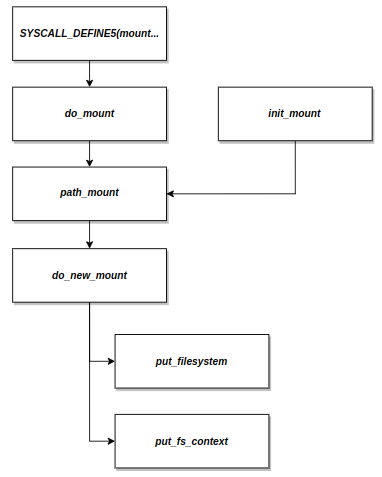
  <figcaption>Caminho percorrido pelo sistema de montagem</figcaption>
  </center>
</figure>

<figure>
  <center> 
    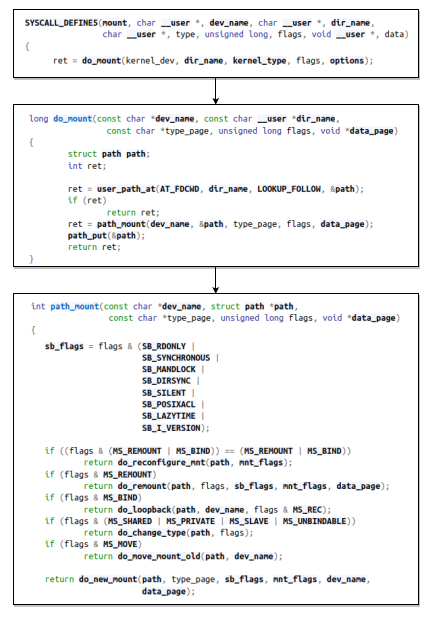
  <figcaption>Código percorrido pela chamada de sistema mount</figcaption>
  </center>
</figure>

É válido destacar (como visto na figura acima) que existem alguns "*do_mounts*" possíveis, e podem ser acionados através das *flags* passadas para a syscall. Temos como exemplo a possibilidade de remontar, mudar o tipo, reconfigurar um sistema já montado e utilizar como loopback, isto é, poder ser usado como dispositivo de bloco. Mas por padrão, a função a ser acionado é a *do_new_mount*.

A função *do_new_mount* traça dois caminhos, por assim dizer. Um caminho que irá definir o contexto de montagem que mantem os parâmetros e atributos utilizados na criação ou reconfiguração de um superblock e outro que ira buscar o sistema de arquivos desejado no sistema.

<figure>
  <center> 
    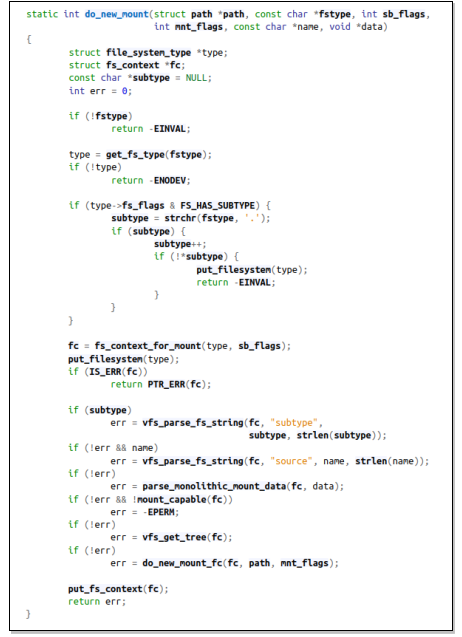
  <figcaption>Código da função do_new_mount</figcaption>
  </center>
</figure>

Agora vamos avaliar como são as estruturas do *file_system_type* e do *fs_context* especificamente do ext4.

*  O que o *get_fs_type* busca com relação ao ext4?  
A função busca pelo ext4 na lista de sistemas de arquivos disponíveis através de seu próprio nome. É possível verificar pela forma como a *struct file_system_type* é definida em */include/linux/fs.h* que todo sistema de arquivo criado com file_system_type possui um apontador para o próximo.

<figure>
  <center> 
    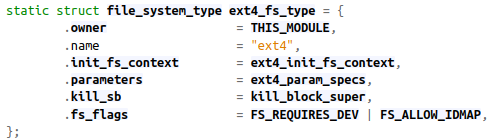
  <figcaption>Definição do file_system_type do ext4</figcaption>
  </center>
</figure>

*   A busca por informações de contexto contém: qual o tipo do sistema de arquivo, um ponteiro para operações utilizadas no próprio contexto, o *path (dentry)*, o propósito da montagem (nova montagem, reconfiguração de uma montagem já existente...), flags para o superblock e mais.  
Abaixo temos o contexto do ext4 em si:

<figure>
  <center> 
    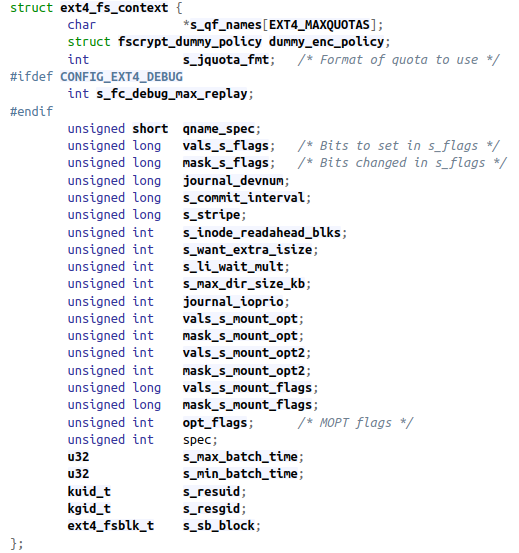
  <figcaption>Contexto de montagem do ext4</figcaption>
  </center>
</figure>

No caso do ext4 destacamos a presença de flags referentes a:
* **EXT4_MAXQUOTAS**: Número de cotas (limites de utilização de espaço no disco, visa a correta utilização e repartição de espaço em disco disponível para todos os usuários e grupos, previnindo que a taxa máxima de utilização seja atinginda impedindo a corretude do funcionamento;
* **s_min_batch_time** e **s_max_batch_time**: Quantidades mínimas e máximas que o sistema deve esperar para realizar operações de escrita síncrona;
* **s_resuid** e **s_resgid**: ID tanto do grupo quanto do usuário que poderá usar os blocos reservados;
* **s_max_dir_size_kb**: Tamanho limite para os diretórios;
* **jounal_ioprio**: A prioridade das operações de entrada e saída no *journal*, indo de 0 a 7, sendo por padrão 3 e 0 a de maior prioridade;
* **s_inode_readahead_blks**: Número máximo de blocos de tabela de inode que o algoritmo de leitura antecipada do ext4 irá pré-ler no cache de buffer;
* **s_commit_interval**: intervalo de tempo para sincronização dos dados e metadados. Por padrão o ext4 define 5 segundos de intervalo, o que diminui a performance, mas possui um ganho na segurança.

#### **Operações através do ext4**

Como havia sido comentado, é reponsabilidade do Sistema Operacional manter abstrações para que seja possível o uso de qualquer sistema de arquivos sem a necessidade de uma implementação própria para cada, sendo assim o ponteiro de operações do sistema apontada para as do sistema de arquivo escolhido. Agora, partindo do *ext4* vamos chegar nessas generalizações.

<figure>
  <center> 
    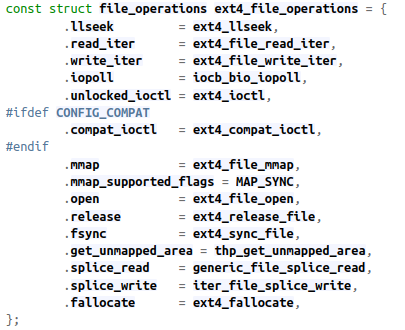
  <figcaption>Operações do sistema de arquivos ext4</figcaption>
  </center>
</figure>

###### **ext4 : WRITE**

<figure>
  <center> 
    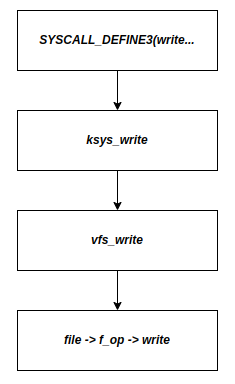
  <figcaption>Abstração da chamada de sistema WRITE realizada pelo sistema operacional</figcaption>
  </center>
</figure>

<figure>
  <center> 
    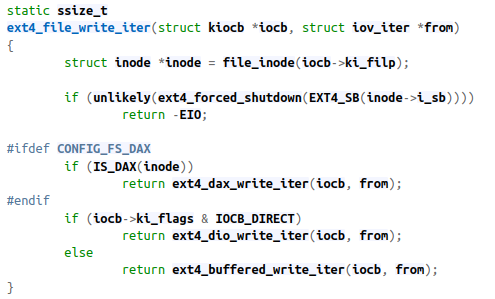
  <figcaption>Chamada WRITE realizada pelo ext4</figcaption>
  </center>
</figure>

Vale notar que o ext4 aceita DAX (Direct Access) e o DIO (Direct I/O) que permitem o acesso direto a arquivos armazenados na memória persistente ou em um dispositivo de bloco. Sem esse suporte em um sistema de arquivos, o cache de página geralmente é usado para armazenar em buffer leituras e gravações em arquivos e requer uma operação de cópia extra. Os acessos diretos removem a operação de cópia extra realizando leituras e gravações diretamente no dispositivo de armazenamento.

<figure>
  <center> 
    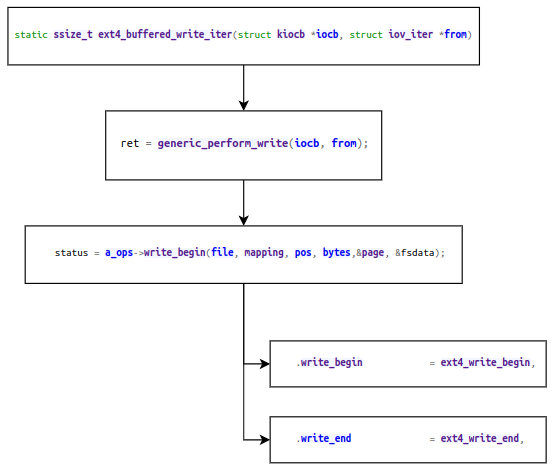
  <figcaption>Caminho percorrido até chegar na função de escrita efetivamente</figcaption>
  </center>
</figure>

Algumas operações realizadas pelas funções percorridas no caminho:
*  **ext4_buffered_write_iter** : realiza algumas checagens iniciais de limite de tamanho, utiliza de semáforo para os inodes evitando possiveis problemas através das funções *inode_lock* e *inode_unlock*;
*  **generic_perform_write** : aponta para os dados, recupera o offset e o número de bytes a serem gravados a partir do inode;
*  **a_ops** : ponteiro para as funções do sistema ext4;
*  **ext4_write_begin** : inicializa o Journal, calcula o tamanho a ser reservado para realizar a modificação de uma única página em uma única transação, que pode incluir vários blocos de alocações de blocos;
*  **ext4_write_end** : recupera o novo tamanho do inode, realiza diversos truncamento caso tenham sido alocados mais blocos do que os copiados, atualiza ou zera os buffers caso necessário.

<figure>
  <center> 
    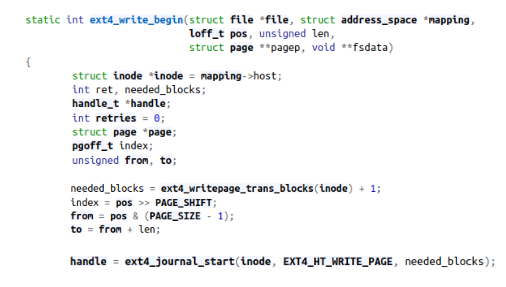
  <figcaption>Alguns trechos de código do ext4_write_begin</figcaption>
  </center>
</figure>

<figure>
  <center> 
    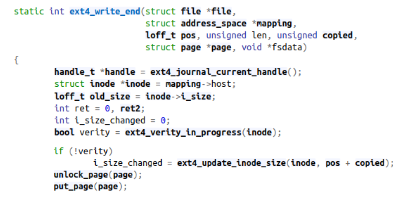
  <figcaption>Alguns trechos de código do ext4_write_end</figcaption>
  </center>
</figure>

### **Ext4 é o melhor sistema de arquivos que podemos usar?**

É claro que quando tratamos de computação devemos sempre nos perguntar "melhor para que?".  
Mas em 2008, Thedorore Tso,o principal desenvolvedor dos sistemas ext3 e ext4, disse que utilizava de uma tecnologia antiga e funcionaria como um "tapa-buraco". Ele acreditava que o BtrFS (b-tree file system) possuia uma melhor escalabilidade e era de mais fácil gerenciamento.  
Mesmo assim, com o passar dos anos o ext4 ganhou melhorias quanto criptografia, verificação de metadados que unidos da presença do journaling se tornou uma das opções mais seguras e estáveis, sendo o sistema de arquivos padrão para maioria das distribuições Linux até hoje.